# First Amateur VLBI experiment with LilacSat-2

On 2018-02-23, [Wei Mingchuan BG2BHC](https://twitter.com/bg2bhc) published a time synchronized recording of LilacSat-2 made from groundstations at Chongqing and Harbin (baseline of 2500km).

The recording and Wei's MATLAB files to process it can be found in [amateur-vlbi](https://github.com/bg2bhc/amateur-vlbi).

Here I process the recording using some techniques from GNSS signal processing.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io
import ephem

c = 299792458 # speed of light in m/s

The recording is stored in a MATLAB file. The path below should be adjusted to the location of the file.

In [2]:
matfile = scipy.io.loadmat('/home/daniel/amateur-vlbi/lilacsat2_sync_20180223_slice.mat')

The contents of the MATLAB file are as follows:

In [3]:
matfile

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Feb 24 00:28:20 2018',
 '__version__': '1.0',
 'rx_freq': array([[437275000]], dtype=int32),
 'rx_rate': array([[250000]], dtype=int32),
 'rx_time_chongqing': array([[  1.51933739e+09]]),
 'rx_time_harbin': array([[  1.51933739e+09]]),
 'signal_sync_chongqing_slice': array([[ -2.44148017e-04+0.00064089j,   7.32444052e-04-0.00067141j,
           6.10370073e-04-0.00024415j, ...,   1.15970313e-03+0.00024415j,
          -3.05185022e-05+0.0003357j ,   1.22074009e-04+0.00064089j]]),
 'signal_sync_harbin_slice': array([[ 0.00030519-0.00061037j, -0.00036622-0.00012207j,
          0.00021363+0.00073244j, ..., -0.00067141+0.00070193j,
          0.00036622+0.00021363j, -0.00045778-0.00045778j]])}

We get the sample rate `fs` and the two channel IQ `signal` from the MATLAB file.

In [4]:
fs = matfile['rx_rate'][0][0]
signal_chongqing = matfile['signal_sync_chongqing_slice'][0,:]
signal_harbin = matfile['signal_sync_harbin_slice'][0,:]
signal = np.vstack((signal_chongqing, signal_harbin))

The time difference between both recordings is on the order of 1us (or 300m), much smaller that the sample period, so we can ignore it for now.

In [5]:
clock_difference = (matfile['rx_time_chongqing'] - matfile['rx_time_harbin'])[0][0]
clock_difference

-1.1920928955078125e-06

Now we plot the spectrum of both recordings. They show several 9k6 GMSK packets transmitted by LilacSat-2 at 437.225MHz.

Note that the frequency of the signal is seen higher in Chongqing than in Harbin due to the Doppler effect. LilacSat-2 is moving away from Harbin and towards Chongqing, since this is a north to south pass over China.

In [6]:
def spectrum_plot(x, title = None):
    f, t, Sxx = scipy.signal.spectrogram(x, fs, return_onesided=False)
    f = np.fft.fftshift(f)
    plt.imshow(np.fft.fftshift(np.log10(Sxx), axes=0), extent = [t[0],t[-1],f[-1],f[0]], aspect='auto', cmap='viridis')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    if title:
        plt.title(title)

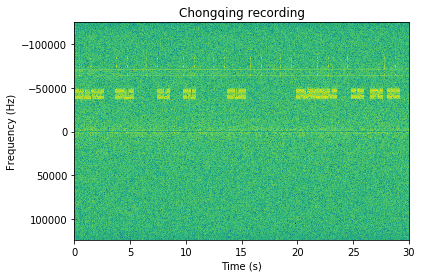

In [7]:
spectrum_plot(signal[0,:], 'Chongqing recording')

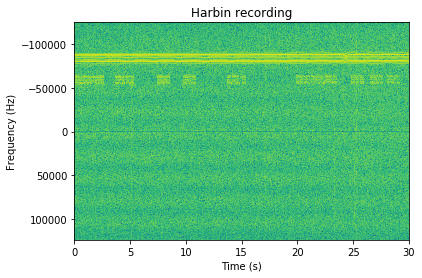

In [8]:
spectrum_plot(signal[1,:], 'Harbin recording')

Now we will convert both signals to baseband. The frequency seen at Chongqing is approximately -44kHz and the frequency seen at Harbin is approximately -60.5kHz. We use these frequencies to generate a "local oscillator" (or NCO) that brings both signals near 0Hz.

In [9]:
f_lo_chongqing = -44000
f_lo_harbin = -60500
f_lo = np.vstack((f_lo_chongqing, f_lo_harbin))
lo = np.exp(-1j*2*np.pi*np.arange(signal.shape[1])*f_lo/fs)

We will use a FIR filter to filter the signal. The filter is designed for a cutoff at a normalized frequency of 0.1, or 25kHz.

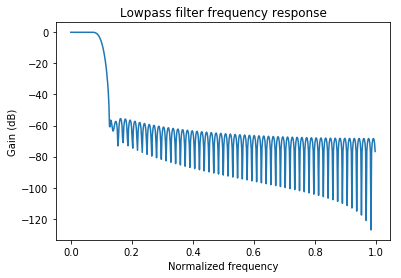

In [10]:
lowpass = scipy.signal.firwin(128, 0.1)
freqz = scipy.signal.freqz(lowpass)
plt.plot(freqz[0]/np.pi, 20*np.log10(np.abs(freqz[1])))
plt.title('Lowpass filter frequency response')
plt.xlabel('Normalized frequency')
plt.ylabel('Gain (dB)');

Now we apply the LO and filter to the signal.

In [11]:
signal_bb = scipy.signal.lfilter(lowpass, 1, signal*lo)

The results of frequency translation and filtering are as follows:

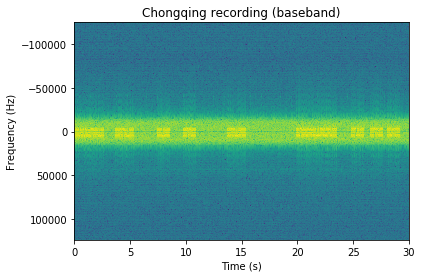

In [12]:
spectrum_plot(signal_bb[0,:], 'Chongqing recording (baseband)')

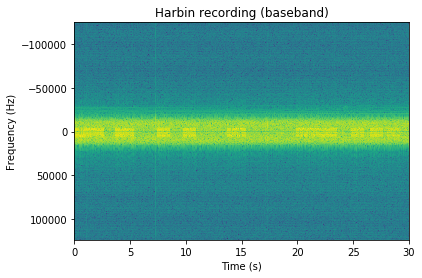

In [13]:
spectrum_plot(signal_bb[1,:], 'Harbin recording (baseband)')

The following function try to estimate the position of a correlation peak, given "prompt", "early" and "late" correlators. The idea is taken from GNSS signal processing. The functions can be used as small correction (smaller than 0.5 samples) to obtain a resolution for the delay better than one sample when doing the correlation.

There are two functions depending on the shape of the correlation peak. The `triangle` function assumes that the correlation peak is an isosceles triangle (which is the case for a rectangular pulse shaping filter). The `parabola` function assumes that the correlation peak is a parabola (which is an approximation of what happens for a continuous pulse shaping filter). Here we use the parabola, as the correlation peaks are well matched by a parabola.

In [215]:
def peak_estimator_triangle(x):
    return np.clip(0.5*(x[2]-x[0])/(x[1]-min(x[0],x[2])), -0.5, 0.5)

def peak_estimator_parabola(x):
    return np.clip(0.5*(x[2]-x[0])/(2*x[1]-x[0]-x[2]), -0.5, 0.5)

peak_estimator = peak_estimator_parabola

This is the main open-loop correlation algorithm. The algorithm works by using an FFT of size `N` in contiguous non-overlapping blocks.

Correlation is done writing the convolution in time domain as a product in the frequency domain. Search in Doppler is done by circular shifting one of the signals in the frequency domain, which amounts multiplying by a complex exponential. Search in Doppler only provides a very coarse frequency estimate and it is only performed here to maximize the correlation peak, since the correlation has a `sinc()`-like response in frequency. Fine frequency will be calculated later using phase techniques.

For each block of `N` samples, the Doppler bin producing the largest correlation is found, and the delay where the correlation peak occurs is refined using the `peak_estimator()` function above. We also store the complex correlation to use it later for phase computations.

In [216]:
N = 2**14
hz_per_bin = fs/N
freq_search_hz = 200
bin_search = int(freq_search_hz/hz_per_bin)
steps = signal_bb.shape[1]//N
best_freq_bin = np.empty(steps)
best_time_bin = np.empty(steps)
complex_corr = np.empty(steps, dtype='complex64')
for step in range(steps):
    f = np.fft.fft(signal_bb[:,step*N:(step+1)*N])
    best_corr = -np.inf
    for freq_bin in range(-bin_search,bin_search):
        corr = np.fft.ifft(f[0,:]*np.conj(np.roll(f[1,:], freq_bin)))
        corr_max = np.max(np.abs(corr))
        if corr_max > best_corr:
            best_corr = corr_max
            best_freq_bin[step] = freq_bin
            j = np.argmax(np.abs(corr))
            best_time_bin[step] = j + peak_estimator(np.abs(corr[j-1:j+2]))
            complex_corr[step] = corr[j]

The vector `t` below represents the times of measurement of each correlation. `t` = 0 corresponds to the start of the recording. The time for each correlation is taken as the time for the midpoint of the correlation interval (hence the `0.5` below).

In [217]:
t = (0.5 + np.arange(steps))*N/fs

Since the signal is continuous but packetised, a meaningful correlation is only produced during packet transmissions. Also, the beginning and end of each packet contain a periodic preamble which causes many self-correlation peaks and confuses the cross-correlation. Therefore, the correlation is only valid when the data is transmitted. Since the data is scrambled, it provides a good cross-correlation with a single peak.

We can plot the magnitue of the correlation to see clearly when the packets are transmitted.

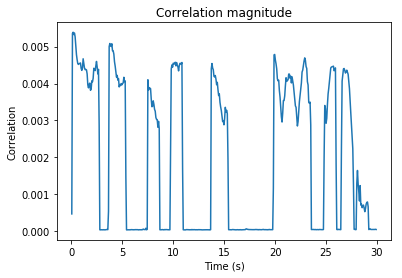

In [218]:
correlating = np.abs(complex_corr) > 1e-3
plt.plot(t, np.abs(complex_corr))
plt.ylabel('Correlation')
plt.xlabel('Time (s)')
plt.title('Correlation magnitude');

The correlation delay can be converted directly to a physical magnitude: delta-range in meters. When doing so, we also incorporate the clock offset between receivers.

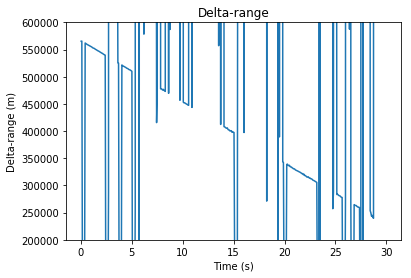

In [219]:
delta_range = (best_time_bin / fs + clock_difference)*c
plt.plot(t, delta_range)
plt.ylim([200e3, 600e3])
plt.xlabel('Time (s)')
plt.ylabel('Delta-range (m)')
plt.title('Delta-range');

To compute the (accumulated) phase, we need to accumulate the frequency due to the difference of local oscillators used for both signals and the frequency given by the Doppler bin where correlation happens. To this we need to add the unwrapped phase obtained from the complex correlation.

Note that phase is computed "for the middle" of each block of `N` samples, so the accumulated phase due to frequency must be taken referred to the middle of the block (see the computation below).

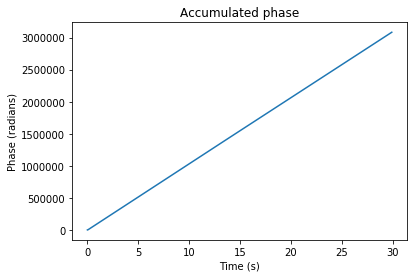

In [220]:
accum_phase = 2*np.pi*(f_lo_chongqing - f_lo_harbin)*N/fs*np.arange(steps) + 2*np.pi*np.cumsum(best_freq_bin)

# here we adjust accumulated phase due to frequency to be referred to the middle of the block
accum_phase[1:] = 0.5*accum_phase[:-1] + 0.5*accum_phase[1:]
accum_phase[0] = 0.5*accum_phase[0]

accum_phase = accum_phase + np.unwrap(np.angle(complex_corr))

plt.plot(t, accum_phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')
plt.title('Accumulated phase');

The accumulated phase can be converted to physical units (meters) by using the carrier frequency (437.225MHz).

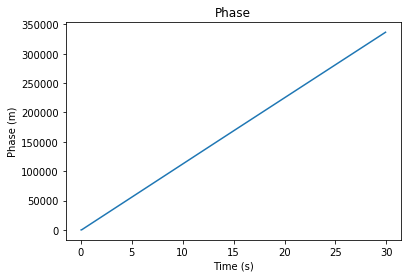

In [221]:
phase_meters = accum_phase/(2*np.pi)*c/437.225e6
plt.plot(t, phase_meters)
plt.xlabel('Time (s)')
plt.ylabel('Phase (m)')
plt.title('Phase');

Delta-frequency and delta-velocity can be obtained by differentiating the phase with respect to time. Note the minus sign in the delta-velocity calculation, due to the sign convention for the phase. The time corrrespoding to each delta-frequency or delta velocity measurement is stored in the vector `t_vel`.

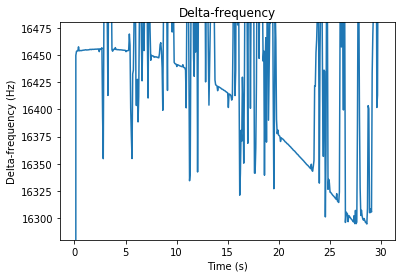

In [222]:
t_vel = 0.5*(t[:-1]+t[1:])
delta_freq = np.diff(accum_phase)/(2*np.pi)*fs/N
plt.plot(t_vel, delta_freq)
plt.xlabel('Time (s)')
plt.ylabel('Delta-frequency (Hz)')
plt.title('Delta-frequency')
plt.ylim([16280, 16480]);

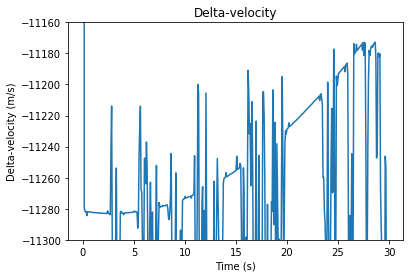

In [223]:
delta_velocity = -np.diff(phase_meters)*fs/N
plt.plot(t_vel, delta_velocity)
plt.xlabel('Time (s)')
plt.ylabel('Delta-velocity (m/s)')
plt.title('Delta-velocity')
plt.ylim([-11.3e3,-11.16e3]);

### Comparison with TLEs

Here we compare the delta-range and delta-velocity with those obtained by using NORAD TLEs and the precise locations of the groundstations.

We use the TLE for LilacSat-2 whose epoch is closest to the recording. The station locations were communicated by BG2BHC.

We use the [pyephem](http://rhodesmill.org/pyephem/) to compute the range and range velocity of the satellite relative to each of the groundstations.

In [224]:
line1 = "LILACSAT-2"
line2 = "1 40908U 15049K   18053.96386647 +.00000361 +00000-0 +23762-4 0  9990"
line3 = "2 40908 097.4676 058.7809 0017622 066.9267 293.3820 15.13412106134091"
sat = ephem.readtle(line1, line2, line3)

chongqing = ephem.Observer()
chongqing.lat, chongqing.lon, chongqing.elevation = '29.613221', '106.511251', 320

harbin = ephem.Observer()
harbin.lat, harbin.long, harbin.elevation = '45.732948', '126.627026', 200

The recording start date is obtained from the MATLAB file, where it is codified as seconds elapsed since the UNIX epoch.

In [225]:
recording_start = ephem.Date('1970/01/01 00:00:00') + matfile['rx_time_chongqing'][0][0]*ephem.second

Now we can compute the delta-range and delta-velocity using the TLEs, for each of the times where we made a measurement with correlation. Note that the times for sampling delta-range and delta-velocity are different.

In [226]:
delta_range_tle = np.empty_like(delta_range)
delta_velocity_tle = np.empty_like(delta_velocity)

for j,s in enumerate(t):
    chongqing.date = recording_start + s*ephem.second
    harbin.date = chongqing.date
    sat.compute(chongqing)
    r_chongqing = sat.range
    sat.compute(harbin)
    r_harbin = sat.range
    delta_range_tle[j] = r_chongqing - r_harbin

for j,s in enumerate(t_vel):
    chongqing.date = recording_start + s*ephem.second
    harbin.date = chongqing.date
    sat.compute(chongqing)
    vel_chongqing = sat.range_velocity
    sat.compute(harbin)
    vel_harbin = sat.range_velocity
    delta_velocity_tle[j] = vel_chongqing - vel_harbin

Below we plot the residuals, i.e., the difference between the measured delta-range and the delta-range computed with the TLEs, and similarly for the delta-velocity.

There is a bias in each of the residuals. This might be to an imprecission of the TLEs (which are not very precise) or to some bias introduced by the calculations of delta-range and delta-velocity using correlations. This will be studied in the future.

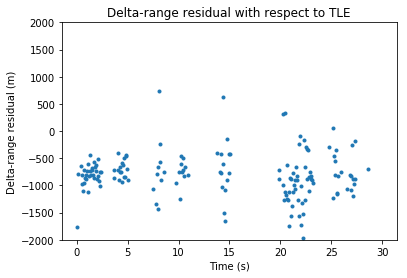

In [227]:
plt.plot(t, delta_range - delta_range_tle, '.')
plt.ylim([-2e3, 2e3])
plt.xlabel('Time (s)')
plt.ylabel('Delta-range residual (m)')
plt.title('Delta-range residual with respect to TLE');

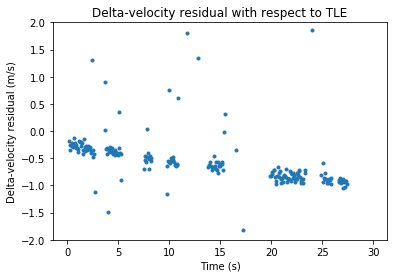

In [228]:
plt.plot(t_vel, delta_velocity - delta_velocity_tle, '.')
plt.ylim([-2, 2])
plt.xlabel('Time (s)')
plt.ylabel('Delta-velocity residual (m/s)')
plt.title('Delta-velocity residual with respect to TLE');

### Correlation with resampling

Since the delta-velocity is quite large, long correlation intervals are not usable, as the correlation peak moves during the correlation interval, due to the change in delta-range. To cancel out this motion and allow for longer correlation intervals, here we propose an algorithm that resamples the second signal (Harbin) before correlating against the first signal (Chongqing).

The resampling algorithm used is an arbitrary resampling using `sinc` interpolation.

As we already have good estimates for the delay and frequency difference, we perform the correlations in the time domain and only use a small number of correlators. By applying our estimates for the frequency difference, no additional frequency corrections or searches are needed, even for long coherent integration intervals.

First we calculate the "baseband" phase. This calculation is analogous to the `accum_phase` computation above but without taking into account the local oscillators that we have used to mix the signals down to baseband.

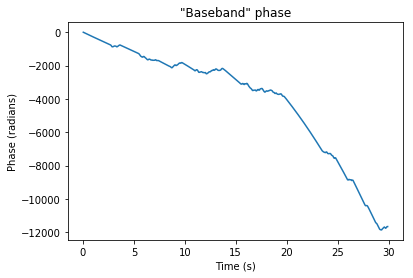

In [33]:
bb_phase = 2*np.pi*np.cumsum(best_freq_bin)

# here we adjust accumulated phase due to frequency to be referred to the middle of the block
bb_phase[1:] = 0.5*bb_phase[:-1] + 0.5*bb_phase[1:]
bb_phase[0] = 0.5*accum_phase[0]

bb_phase = bb_phase + np.unwrap(np.angle(complex_corr))

plt.plot(t, bb_phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')
plt.title('"Baseband" phase');

Using the baseband phase, we compute the baseband frequency (or rather frequency difference). This will be used for frequency correction before correlation. The units here are rad/sample, which are more useful later.

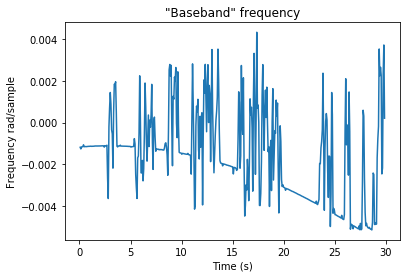

In [34]:
bb_freq = np.diff(bb_phase)/N
plt.plot(t_vel, bb_freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency rad/sample')
plt.title('"Baseband" frequency');

The baseband phase and frequency are so far measured for each FFT block (i.e., every `N` samples). We will need a measurement every sample, so the measurements need to be upsampled. To do so, we repeat the baseband frequency (i.e., use zero-order hold interpolation) and integrate to get the baseband phase.

We also calculate, for each sample, the delay in samples that has to be applied to the Harbin signal when resampling. This is calculated by using the `delta_velocity` computed above, interpolating by zero-order hold and integrating.

In [295]:
bb_phase_sample = np.cumsum(np.repeat(bb_freq, N))
delay_sample = np.cumsum(np.repeat(-delta_velocity/c,N))

The function below is a simple arbitrary resampler using `sinc` interpolation. Given a vector `x` and an index `t` which is not necessarily an integer, the function returns "`x[t]`" by interpolation.

In [99]:
def arbitrary_sampling(x, t):
    n = 20
    j = int(np.round(t))
    if j-n < 0 or j+n > x.size:
        return 0
    taps = np.sinc(np.arange(-n,n+1) - t + j)
    return np.sum(taps * x[j-n:j+n+1])

These are the parameters for our correlation algorithm. `coherent_len` is the coherent integration interval in samples. Non-coherent integrations are not used. `2*ncorrs+1` is the number of correlators used.

In [246]:
coherent_len = 16*N
step = N
steps = (signal_bb.shape[1]-coherent_len)//step
corrected_delta_range = np.zeros(steps)
ncorrs = 5

The correlation algorithm is in the cell below. It takes a long time to run, since arbitrary resampling is quite expensive.

For each correlation interval, we first use `delay_sample` to calculate `delay_corrected`, which gives the appropriate sampling points for the Harbin signal. Then we use `arbitrary_sampling` to build a resampled version of the Harbin signal according to `delay_sample`. We also mix this signal with the frequency offset using `bb_phase_sample`. Finally, a correlation is done for each correlator by shifting the Chongqing signal (the same Harbin signal is used in all correlators to avoid resampling for each correlator).

In [ ]:
correlators = np.empty((steps,2*ncorrs+1), dtype='complex64')
for k in range(1,steps):
    sample_start = k * step
    delay = best_time_bin[sample_start//N]
    delay_correct = delay_sample[sample_start:sample_start+coherent_len] - delay_sample[sample_start] \
        + np.arange(coherent_len)
    resampled_with_doppler = np.empty_like(delay_correct, dtype='complex64')
    for j, tt in enumerate(delay_correct):
        resampled_with_doppler[j] = np.conj(arbitrary_sampling(signal_bb[1,:], sample_start - delay + tt))
        resampled_with_doppler[j] *= np.exp(-1j * bb_phase_sample[sample_start + j])
    for j in range(-ncorrs,ncorrs+1):
        correlators[k,j+ncorrs] = np.sum(signal_bb[0, sample_start - j: sample_start+coherent_len -j] * resampled_with_doppler)

The second part of the algorithm uses peak estimation to compute the `corrected_delta_range` according to the correlations computed above. This part of the algorithm has been separated from the expensive part (computing correlations) to allow trying quickly out different algorithms with the correlations (avoiding to recompute correlations).

In [270]:
for k in range(1,steps):
    sample_start = k * step
    delay = best_time_bin[sample_start//N]
    j = np.argmax(np.abs(correlators[k,:]))
    peak_est = peak_estimator(np.abs(correlators[k,j-1:j+2])) if correlators[k,j-1:j+2].size == 3 else 0
    corrected_delay = delay + ncorrs - j - peak_est
    corrected_delta_range[k] = (corrected_delay / fs + clock_difference)*c

To evaluate the performance of the algorithm, we compute and plot the residual against TLEs in the same manner we have done above.

In [296]:
t_corrected = np.arange(corrected_delta_range.size)*step/fs
corrected_delta_range_tle = np.empty_like(corrected_delta_range)

for j,s in enumerate(t_corrected):
    chongqing.date = recording_start + s*ephem.second
    harbin.date = chongqing.date
    sat.compute(chongqing)
    r_chongqing = sat.range
    sat.compute(harbin)
    r_harbin = sat.range
    corrected_delta_range_tle[j] = r_chongqing - r_harbin

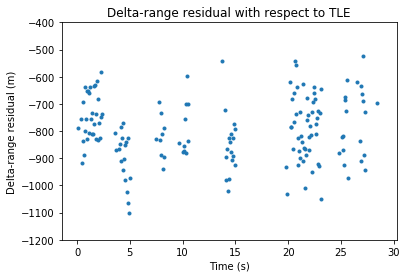

In [297]:
plt.plot(t_corrected, corrected_delta_range - corrected_delta_range_tle, '.')
plt.ylim([-1200, -400])
plt.xlabel('Time (s)')
plt.ylabel('Delta-range residual (m)')
plt.title('Delta-range residual with respect to TLE');